In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os

from torch.utils.data import random_split
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

print("Set device to:", device)

Set device to: cuda


In [2]:
# Dummy dataset creator:
class Dummy_PMSSMDataset(Dataset):
    def __init__(self, n_samples=10000):
        super().__init__()
        self.x = torch.randn(n_samples, 19)

        # Dummy "physics-inspired" target
        # Nonlinear function + noise
        self.y = (
            torch.sum(self.x[:, :5] ** 2, dim=1)
            + torch.sin(self.x[:, 5:10]).sum(dim=1)
            + 0.1 * torch.randn(n_samples)
        )
        self.y = self.y.unsqueeze(1)  # (N, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [3]:
# Create real dataset:
import uproot

# Open ROOT file
file = uproot.open("data/ntuple.18192176.0.root")

# Access the tree
tree = file["susy"]

# Print branches starting with "IN_"
print("Branches in 'susy' starting with 'IN_':")
print("-" * 40)

for branch_name in tree.keys():
    if branch_name.startswith("IN_") or branch_name.startswith("MO_"):
        if "err" in branch_name: continue
        print(f"{branch_name}: {tree[branch_name].array()}")
        
branches = ["IN_meL", "IN_meR", "IN_mtauL", "IN_mtauR", "IN_mqL1", "IN_muR", "IN_mdR", "IN_mqL3", "IN_mtR", "IN_mbR", "IN_M_1", "IN_M_2", "IN_mu", "IN_M_3", "IN_At", "IN_Ab", "IN_Atau", "IN_mA", "IN_tanb"]
print(f"Overall: n_branches = {len(branches)}")

arrays = tree.arrays(branches, library="np")
print(arrays)

branch_target = ["MO_Omega"]
array_target = tree.arrays(branch_target, library="np")
print("array_target:", array_target)

Branches in 'susy' starting with 'IN_':
----------------------------------------
IN_M_1: [632, -333, 1.55e+03, 595, -581, ..., -12.5, -1.76e+03, 1.02e+03, -1.24e+03]
IN_M_2: [1.3e+03, -1.4e+03, 369, -634, ..., -1.63e+03, 1.9e+03, -1.55e+03, -70.2]
IN_M_3: [2.39e+03, 1.34e+03, 3.98e+03, 1.62e+03, ..., 1.79e+03, 2.17e+03, 1.31e+03]
IN_At: [5.56e+03, -180, 659, -6.16e+03, ..., -3.73e+03, -550, 4.84e+03, 7.76e+03]
IN_Ab: [-669, -391, -1.14e+03, -1.5e+03, 1.8e+03, ..., -567, 1.9e+03, -750, -426]
IN_Atau: [412, -935, 881, 638, -1.37e+03, ..., -1.1e+03, 1.9e+03, 571, -60.2, -1.85e+03]
IN_mu: [1.4e+03, 1.71e+03, -747, 691, 1.8e+03, ..., 1.51e+03, -634, 1.18e+03, 4.19]
IN_tanb: [12.2, 20.3, 30.4, 18.4, 52.4, 41, ..., 48.1, 28.4, 4.07, 18.8, 51.6, 11.7]
IN_mA: [2.82e+03, 644, 3.79e+03, 3.95e+03, ..., 2.06e+03, 2.35e+03, 1.65e+03, 4.89e+03]
IN_meL: [1e+04, 1e+04, 1e+04, 1e+04, 1e+04, ..., 1e+04, 1e+04, 1e+04, 1e+04, 1e+04]
IN_mmuL: [1e+04, 1e+04, 1e+04, 1e+04, 1e+04, ..., 1e+04, 1e+04, 1e+04, 1e+

(array([6109.,  430.,  110.,   51.,   43.,   46.,   37.,   27.,   27.,
          30.]),
 array([1.52736902e-07, 9.97001380e-02, 1.99400112e-01, 2.99100101e-01,
        3.98800075e-01, 4.98500049e-01, 5.98200083e-01, 6.97900057e-01,
        7.97600031e-01, 8.97300005e-01, 9.96999979e-01]),
 <BarContainer object of 10 artists>)

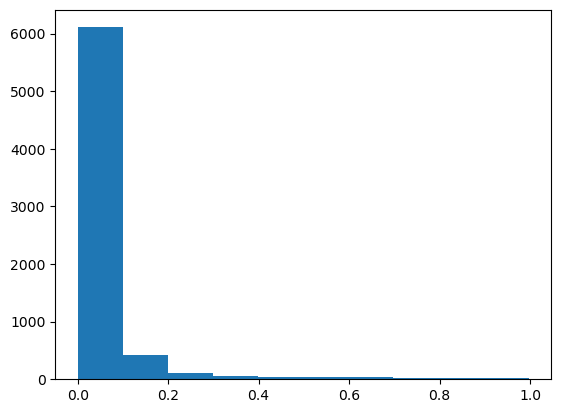

In [4]:
class PMSSMDataset(Dataset):
    def __init__(self, n_samples=10_000):
        super().__init__()
        
        # create numpy array from dictionary:
        X = np.column_stack([arrays[branch] for branch in branches])
        # convert to tensor:
        X = torch.from_numpy(X).float()
        
        # print(X.shape)

        # normalise:
        mean = X.mean(dim=0)
        std  = X.std(dim=0) + 1e-8

        X_norm = (X - mean) / std
        self.x = X_norm

        # Define target
        Y = array_target["MO_Omega"]
        # prune -1 values:
        self.x = self.x[ Y != -1. ]
        Y = Y[ Y != -1. ]        
        
        # temporary?: prune away Y values 1 and above:
        # Y[ Y > 10 ] = 10
        self.x = self.x[ Y < 1 ]
        Y = Y[ Y < 1 ]
        
        Y = torch.from_numpy(Y).float()

        # normalise Y:
        global mean_Y
        global std_Y
        mean_Y = Y.mean(dim=0)
        std_Y = Y.std(dim=0) + 1e-8
        
        Y_norm = (Y - mean_Y) / std_Y
        self.y = Y_norm

        self.y = self.y.unsqueeze(1)  # (N, 1)
        
        # prune X and Y to match n_samples:
        self.x = self.x[:n_samples]
        self.y = self.y[:n_samples]
        
        # print("self.x.shape:", self.x.shape)
        # print("self.y.shape:", self.y.shape)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = PMSSMDataset()

plt.hist(dataset.y * std_Y + mean_Y)

In [5]:
class PMSSMTransformer(nn.Module):
    def __init__(
        self,
        n_params=19,
        d_model=64,
        nhead=8,
        num_layers=4,
        dim_feedforward=256,
        dropout=0.1,
    ):
        super().__init__()

        # Embed each scalar parameter
        self.input_embed = nn.Linear(1, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        self.regressor = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 1),
        )

    def forward(self, x):
        # x: (batch, 19)
        x = x.unsqueeze(-1)               # (batch, 19, 1)
        x = self.input_embed(x)           # (batch, 19, d_model)

        x = self.encoder(x)               # (batch, 19, d_model)

        x = x.mean(dim=1)                 # pool over parameters
        y = self.regressor(x)             # (batch, 1)

        return y


In [17]:
import torch
import torch.nn as nn

class PMSSMFeedForward(nn.Module):
    def __init__(
        self,
        n_params=19,
        d_model=64,
        num_layers=4,
        dim_feedforward=256,
        dropout=0.1,
    ):
        super().__init__()

        # Embed each scalar parameter
        self.input_embed = nn.Linear(1, d_model)

        # Build a stack of fully connected layers
        layers = []
        in_features = n_params * d_model
        for _ in range(num_layers):
            layers.append(nn.Linear(in_features, dim_feedforward))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_features = dim_feedforward
        self.fc_layers = nn.Sequential(*layers)

        # Output layer
        self.regressor = nn.Linear(dim_feedforward, 1)

    def forward(self, x):
        # x: (batch, n_params)
        x = x.unsqueeze(-1)              # (batch, n_params, 1)
        x = self.input_embed(x)          # (batch, n_params, d_model)
        x = x.flatten(start_dim=1)       # (batch, n_params * d_model)
        x = self.fc_layers(x)            # (batch, dim_feedforward)
        y = self.regressor(x)            # (batch, 1)
        return y


In [6]:
def train_with_validation(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device="cpu",
    epochs=30,
    early_stopping=True,
    patience=500,        # early stopping patience
):
    model.to(device)

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    best_model_state = None
    counter = 0

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y)
                val_loss += loss.item() * x.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(
            f"Epoch {epoch:03d} | "
            f"Train MSE = {train_loss:.6f} | "
            f"Val MSE = {val_loss:.6f}"
        )

        if early_stopping:
            # ---- Early Stopping Check ----
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()  # save best weights
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

    # ---- Load best weights before returning ----
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses


In [7]:
# dataset = PMSSMDataset(n_samples=30)
dataset = PMSSMDataset(n_samples=10_000)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(
    train_dataset, batch_size=256, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=256, shuffle=False
)


In [ ]:
# Train transformer:
model = PMSSMTransformer(
    d_model=64,
    nhead=8,
    num_layers=4,
)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.MSELoss()

train_losses, val_losses = train_with_validation(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device=device,
    epochs=5_000,
    early_stopping=False
)

Epoch 000 | Train MSE = 1.103000 | Val MSE = 0.584497
Epoch 001 | Train MSE = 1.063805 | Val MSE = 0.533806
Epoch 002 | Train MSE = 1.058036 | Val MSE = 0.514985
Epoch 003 | Train MSE = 1.053003 | Val MSE = 0.516949
Epoch 004 | Train MSE = 1.050693 | Val MSE = 0.523644
Epoch 005 | Train MSE = 1.048547 | Val MSE = 0.525664
Epoch 006 | Train MSE = 1.051644 | Val MSE = 0.518978
Epoch 007 | Train MSE = 1.050310 | Val MSE = 0.524781
Epoch 008 | Train MSE = 1.054472 | Val MSE = 0.523769
Epoch 009 | Train MSE = 1.048845 | Val MSE = 0.529160
Epoch 010 | Train MSE = 1.045877 | Val MSE = 0.556218
Epoch 011 | Train MSE = 1.057158 | Val MSE = 0.510880
Epoch 012 | Train MSE = 1.047026 | Val MSE = 0.534689
Epoch 013 | Train MSE = 1.049650 | Val MSE = 0.510523
Epoch 014 | Train MSE = 1.054719 | Val MSE = 0.513362
Epoch 015 | Train MSE = 1.049504 | Val MSE = 0.518111
Epoch 016 | Train MSE = 1.050859 | Val MSE = 0.513733
Epoch 017 | Train MSE = 1.048380 | Val MSE = 0.532117
Epoch 018 | Train MSE = 1.04

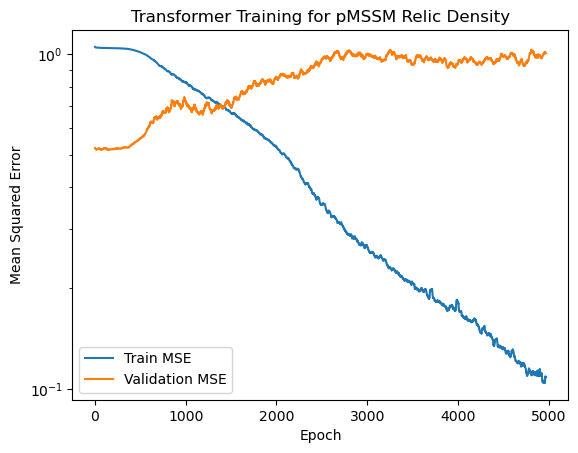

In [9]:
def rolling_average(x, window=30):
    x = np.asarray(x)
    return np.convolve(x, np.ones(window) / window, mode="valid")
    
plt.figure()
plt.plot(rolling_average(train_losses), label="Train MSE")
plt.plot(rolling_average(val_losses), label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("Transformer Training for pMSSM Relic Density")
plt.yscale('log')
plt.show()

# Compare random points

In [10]:
import random

def compare_random_predictions(model, mode='validation', device="cpu", n_points=3):
    model.eval()
    model.to(device)

    if mode == 'validation':
        print("\nComparison on random validation points:")
        dataset = val_dataset
    elif mode == 'train':
        print("\nComparison on random training points:")
        dataset = train_dataset
    else: raise ValueError("Unsupported mode! Should be validation, train.")
        
    # print(len(dataset), n_points)
    indices = random.sample(range(len(dataset)), n_points)

    print("-" * 90)
    print(f"{'Index':>6} | {'True Ωh (norm.)²':>20} | {'Predicted Ωh (norm.)²':>23} | {'True Ωh²':>12} | {'Predicted Ωh²':>15}")
    print("-" * 90)

    with torch.no_grad():
        for idx in indices:
            x, y_true = dataset[idx]
            x = x.unsqueeze(0).to(device)      # (1, 19)
            y_pred = model(x).cpu().item()

            # revert normalisation:
            # Y_norm = (Y - self.mean_Y) / self.std_Y
            y_true_nonorm = y_true * std_Y + mean_Y
            y_pred_nonorm = y_pred * std_Y + mean_Y

            print(
                f"{idx:6d} | "
                f"{y_true.item():20.6f} | "
                f"{y_pred:23.6f} | "
                f"{y_true_nonorm.item():12.6f} | "
                f"{y_pred_nonorm:15.6f}"
            )

    print("-" * 90)


In [11]:
# compare training points
compare_random_predictions(
    model,
    mode='train',
    device=device,
    n_points=10,
)


Comparison on random training points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
  5402 |             0.198653 |               -0.099258 |     0.076200 |        0.039161
  3172 |            -0.253369 |               -0.197292 |     0.020000 |        0.026972
  1926 |            -0.285541 |               -0.270652 |     0.016000 |        0.017851
  4975 |            -0.115832 |               -0.153990 |     0.037100 |        0.032356
  6078 |             0.679630 |               -0.029403 |     0.136000 |        0.047846
  4142 |            -0.414208 |               -0.519798 |     0.000003 |       -0.013125
  2629 |            -0.059530 |               -0.312646 |     0.044100 |        0.012630
  5266 |            -0.401522 |               -0.390837 |     0.001

In [12]:
# compare validation points:
compare_random_predictions(
    model,
    mode='validation',
    device=device,
    n_points=3,
)



Comparison on random validation points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
   183 |             0.792233 |                0.055364 |     0.150000 |        0.058385
   627 |            -0.409332 |                0.198088 |     0.000609 |        0.076130
   263 |            -0.357446 |                0.082598 |     0.007060 |        0.061771
------------------------------------------------------------------------------------------


In [13]:
import torch
import matplotlib.pyplot as plt

def scatter_true_vs_pred(
    model,
    mode="validation",
    device="cpu",
    denormalize=True,
):
    model.eval()
    model.to(device)

    if mode == "validation":
        dataset = val_dataset
        title = "Validation set"
    elif mode == "train":
        dataset = train_dataset
        title = "Training set"
    else:
        raise ValueError("Unsupported mode! Should be validation or train.")

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for x, y_true in dataset:
            x = x.unsqueeze(0).to(device)   # (1, n_features)
            y_pred = model(x).cpu().item()

            if denormalize:
                y_true_val = (y_true * std_Y + mean_Y).item()
                y_pred_val = y_pred * std_Y + mean_Y
            else:
                y_true_val = y_true.item()
                y_pred_val = y_pred

            y_true_all.append(y_true_val)
            y_pred_all.append(y_pred_val)

    # --- plot ---
    plt.figure()
    plt.scatter(y_true_all, y_pred_all, alpha=0.5, color = 'orange' if mode == 'validation' else None)
    plt.plot(
        [min(y_true_all), max(y_true_all)],
        [min(y_true_all), max(y_true_all)],
        linestyle='--',
        color='grey'
    )
    plt.xlabel("True Ωh²")
    plt.ylabel("Predicted Ωh²")
    plt.title(f"True vs Predicted Ωh² ({title})")
    plt.tight_layout()
    plt.show()


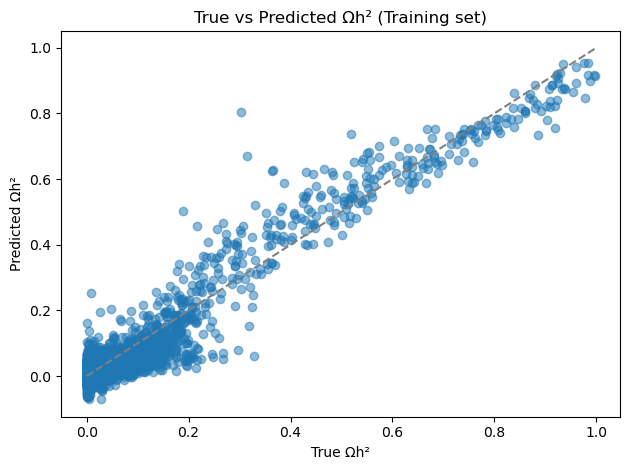

In [14]:
scatter_true_vs_pred(
    model,
    mode='train',
    device=device
)

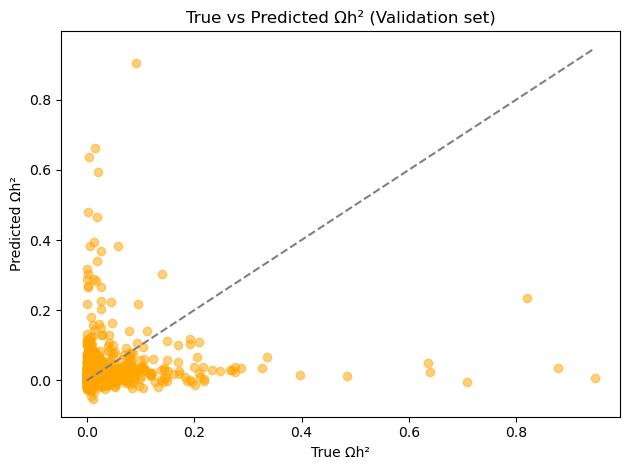

In [15]:
scatter_true_vs_pred(
    model,
    mode='validation',
    device=device
)

# Train MLP

In [24]:
# Train transformer:
model = PMSSMFeedForward(
    d_model = 64,
    num_layers = 4,
    dim_feedforward = 256*2,
)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.MSELoss()

train_losses, val_losses = train_with_validation(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device=device,
    epochs=2_000,
    early_stopping=False
)

Epoch 000 | Train MSE = 1.052018 | Val MSE = 0.520719
Epoch 001 | Train MSE = 1.044089 | Val MSE = 0.510832
Epoch 002 | Train MSE = 1.030878 | Val MSE = 0.527569
Epoch 003 | Train MSE = 1.001535 | Val MSE = 0.459512
Epoch 004 | Train MSE = 0.958343 | Val MSE = 0.470148
Epoch 005 | Train MSE = 0.936240 | Val MSE = 0.459920
Epoch 006 | Train MSE = 0.922370 | Val MSE = 0.458329
Epoch 007 | Train MSE = 0.902503 | Val MSE = 0.471525
Epoch 008 | Train MSE = 0.894196 | Val MSE = 0.474611
Epoch 009 | Train MSE = 0.865888 | Val MSE = 0.462353
Epoch 010 | Train MSE = 0.858042 | Val MSE = 0.442848
Epoch 011 | Train MSE = 0.832109 | Val MSE = 0.477855
Epoch 012 | Train MSE = 0.816413 | Val MSE = 0.416800
Epoch 013 | Train MSE = 0.801488 | Val MSE = 0.418820
Epoch 014 | Train MSE = 0.747190 | Val MSE = 0.425033
Epoch 015 | Train MSE = 0.767047 | Val MSE = 0.481003
Epoch 016 | Train MSE = 0.731016 | Val MSE = 0.519744
Epoch 017 | Train MSE = 0.700741 | Val MSE = 0.419763
Epoch 018 | Train MSE = 0.66

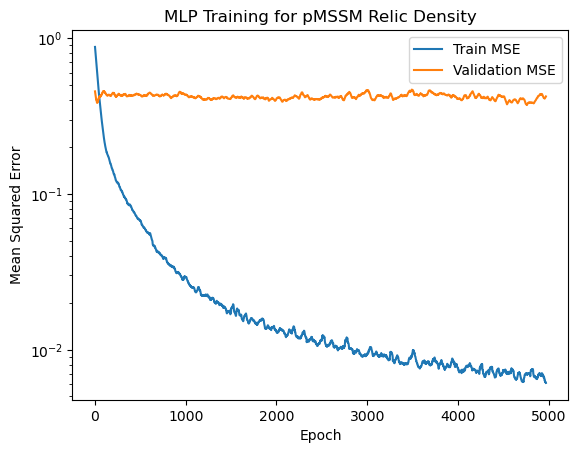

In [19]:
def rolling_average(x, window=30):
    x = np.asarray(x)
    return np.convolve(x, np.ones(window) / window, mode="valid")
    
plt.figure()
plt.plot(rolling_average(train_losses), label="Train MSE")
plt.plot(rolling_average(val_losses), label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.title("MLP Training for pMSSM Relic Density")
plt.yscale('log')
plt.show()

In [20]:
# compare training points
compare_random_predictions(
    model,
    mode='train',
    device=device,
    n_points=10,
)


Comparison on random training points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
  3426 |            -0.412558 |               -0.390192 |     0.000208 |        0.002989
  5001 |             0.993310 |                0.939059 |     0.175000 |        0.168255
   473 |            -0.412517 |               -0.390029 |     0.000213 |        0.003009
  1311 |            -0.290367 |               -0.325584 |     0.015400 |        0.011021
  4883 |            -0.408198 |               -0.394032 |     0.000750 |        0.002511
  3307 |            -0.408665 |               -0.403710 |     0.000692 |        0.001308
  3375 |             0.295974 |                0.257077 |     0.088300 |        0.083464
  5253 |             0.068355 |                0.072119 |     0.060

In [21]:
# compare validation points:
compare_random_predictions(
    model,
    mode='validation',
    device=device,
    n_points=3,
)



Comparison on random validation points:
------------------------------------------------------------------------------------------
 Index |     True Ωh (norm.)² |   Predicted Ωh (norm.)² |     True Ωh² |   Predicted Ωh²
------------------------------------------------------------------------------------------
   182 |            -0.379163 |               -0.382818 |     0.004360 |        0.003906
   403 |            -0.341360 |               -0.345837 |     0.009060 |        0.008503
   146 |            -0.210740 |               -0.225301 |     0.025300 |        0.023490
------------------------------------------------------------------------------------------


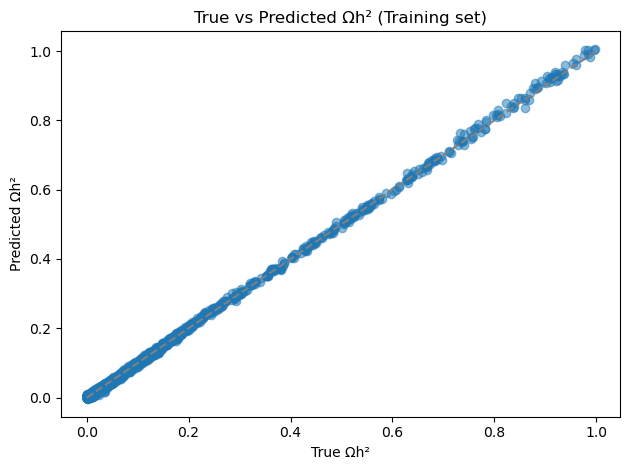

In [22]:
scatter_true_vs_pred(
    model,
    mode='train',
    device=device
)

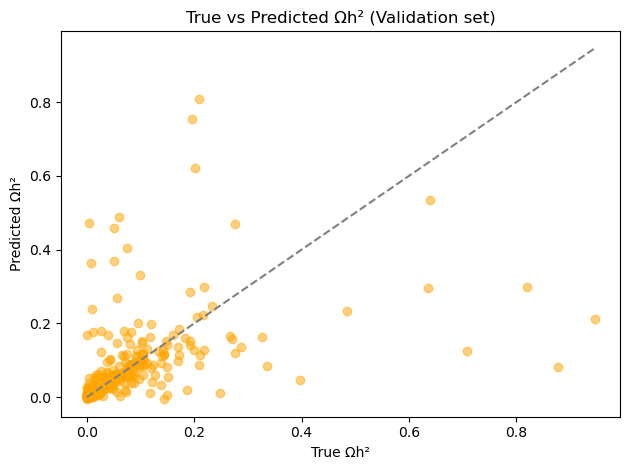

In [23]:
scatter_true_vs_pred(
    model,
    mode='validation',
    device=device
)